In [15]:
'''The purponse of this notebook is to simulate book reviews in light of C. S. Lewis's assertion that only those who love a genre can accurately judge a
book which belongs to it
'''

from enum import Enum, auto
import numpy as np
from scipy.stats import truncnorm

In [16]:
class Category(Enum):
    A = auto()
    B = auto()

In [99]:
import numpy as np

rng = np.random.default_rng()

def sample_trunc_bimodal_normal(
    size: int,
    mu1: float, sigma1: float,
    mu2: float, sigma2: float,
    weight: float,
    low: float = 0.0,
    high: float = 5.0,
    max_iter: int = 1000,
    rng: np.random.Generator = rng,
):
    """
    Draw 'size' samples from a mixture of two normals truncated to [low, high].

    Mixture:
      X ~ weight * N(mu1, sigma1^2) + (1-weight) * N(mu2, sigma2^2)
    then reject samples outside [low, high].
    """
    samples = []
    needed = size
    it = 0

    while needed > 0 and it < max_iter:
        # propose a batch
        n = max(needed, 1000)
        # choose component: True -> component 1, False -> component 2
        choose_1 = rng.random(n) < weight
        # draw from each normal
        x1 = rng.normal(mu1, sigma1, size=n)
        x2 = rng.normal(mu2, sigma2, size=n)
        x = np.where(choose_1, x1, x2)

        # keep only in [low, high]
        mask = (x >= low) & (x <= high)
        accepted = x[mask]

        samples.append(accepted[:needed])
        needed -= accepted.size
        it += 1

    if needed > 0:
        raise RuntimeError("Failed to draw enough truncated samples; adjust parameters.")

    return np.concatenate(samples)


class Reviewer:
    def __init__(self, tol : float, spread: float, random_cats = True, categories=None):
        self.tol = tol
        self.spread = spread
        if random_cats:
            self.init_categories()
        else:
            self.categories = categories
        if self.categories is None:
            raise Exception('Categories not supplied')
        

    def init_categories(self):
        self.categories = {
            Category.A : sample_trunc_bimodal_normal(
                size = 1,
                mu1 = 2,
                sigma1 = .5,
                mu2 = 4,
                sigma2 = .5,
                weight = .5
            ),
            Category.B : sample_trunc_bimodal_normal(
                size = 1,
                mu1 = 2,
                sigma1 = .5,
                mu2 = 4,
                sigma2 = .5,
                weight = .5
            )
        }               

    def review(self, work):
        category_preference = self.categories[work.category]

        if category_preference > self.tol:
            return self.clear_review(work)
        else:
            return self.bias_review(work)

    def _truncnorm_0_5(self, loc: float) -> float:
        """Draw one sample from N(loc, spread^2) truncated to [0, 5]."""
        a, b = (0.0 - loc) / self.spread, (5.0 - loc) / self.spread 
        return truncnorm.rvs(a, b, loc=loc, scale=self.spread)

    def clear_review(self, work):
        """
        'Clear' review case: mean equals work.merit.
        """
        rating = self._truncnorm_0_5(loc=work.merit)
        work.reviews.append(rating)
        return True

    def bias_review(self, work):
        """
        'Bias' case: mean equals the reviewer's category bias
        self.categories[work.category].
        """
        mu = self.categories[work.category]
        rating = self._truncnorm_0_5(loc=mu)
        work.reviews.append(rating)
        return True

In [100]:
class Work:
    def __init__(self, category: Category, merit:float):
        self.category = category
        self.merit = merit
        self.reviews = list()

In [113]:
work_a = Work(Category.A, merit = 4.2)
work_b = Work(Category.B, merit = 3.6)

In [114]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import truncnorm

# helper: draw from N(mean, sd^2) truncated to [low, upp]
def get_truncated_normal(mean=0.0, sd=1.0, low=0.0, upp=1.0):
    a, b = (low - mean) / sd, (upp - mean) / sd  # convert to standard-normal coords [web:74][web:176]
    return truncnorm(a, b, loc=mean, scale=sd)

# assume: work_a, work_b, Reviewer, Category already defined
rng = np.random.default_rng()
num_reviewers = 1000

reviewers = []
mu_tol = 3.0
sd_tol = 0.5  # variance = 0.25

for _ in range(num_reviewers):
    # truncated normal between 0 and 5 with mean 3, sd 0.5
    tol = get_truncated_normal(mean=mu_tol, sd=sd_tol, low=0.0, upp=5.0).rvs(random_state=rng)
    spread = rng.uniform(0.25, 1.0)
    reviewer = Reviewer(tol=tol, spread=spread)
    reviewers.append(reviewer)

for reviewer in reviewers:
    will_review = rng.uniform(0, 5)
    if reviewer.categories[Category.A] > will_review:
        r_a = reviewer.review(work_a)
    if reviewer.categories[Category.B] > will_review:
        r_b = reviewer.review(work_b)

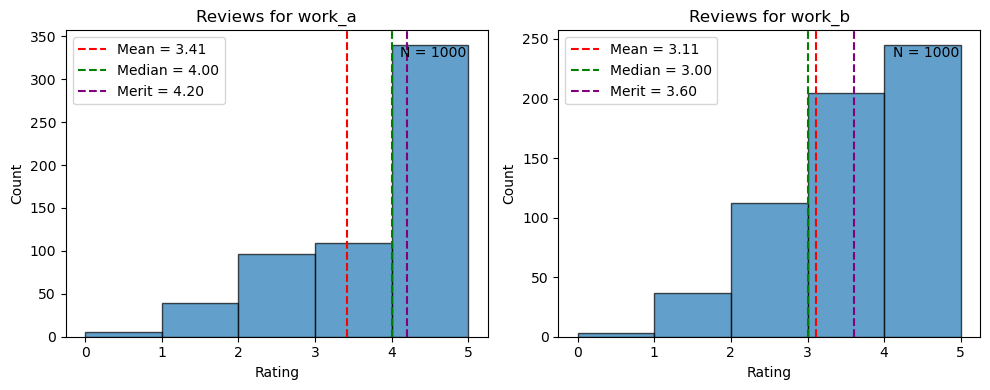

In [115]:
# Assume: work_a, work_b, reviewers, Category, num_reviewers already defined
# and Reviewer.review(work) appends to work.reviews()

# Get ratings directly from works
ratings_a = np.array(work_a.reviews)  # work.reviews() returns list
ratings_b = np.array(work_b.reviews)
ratings_a = np.round(ratings_a)
ratings_b = np.round(ratings_b)

mean_a, median_a = ratings_a.mean(), np.median(ratings_a)
mean_b, median_b = ratings_b.mean(), np.median(ratings_b)

# --------------------------------------------------
# Histograms for ratings with mean/median and N
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# work_a
ax = axes[0]
ax.hist(ratings_a, bins=5, edgecolor="black", alpha=0.7)
ax.set_title("Reviews for work_a")
ax.set_xlabel("Rating")
ax.set_ylabel("Count")

ax.axvline(mean_a, color="red", linestyle="--", label=f"Mean = {mean_a:.2f}")
ax.axvline(median_a, color="green", linestyle="--", label=f"Median = {median_a:.2f}")
ax.axvline(work_a.merit, color='purple', linestyle='--', label=f'Merit = {work_a.merit:.2f}')
ax.legend()

ax.text(
    0.95, 0.95,
    f"N = {num_reviewers}",
    transform=ax.transAxes,
    ha="right", va="top",
    fontsize=10,
)

# work_b
ax = axes[1]
ax.hist(ratings_b, bins=5, edgecolor="black", alpha=0.7)
ax.set_title("Reviews for work_b")
ax.set_xlabel("Rating")
ax.set_ylabel("Count")

ax.axvline(mean_b, color="red", linestyle="--", label=f"Mean = {mean_b:.2f}")
ax.axvline(median_b, color="green", linestyle="--", label=f"Median = {median_b:.2f}")
ax.axvline(work_b.merit, color='purple', linestyle='--', label=f'Merit = {work_b.merit:.2f}')
ax.legend()

ax.text(
    0.95, 0.95,
    f"N = {num_reviewers}",
    transform=ax.transAxes,
    ha="right", va="top",
    fontsize=10,
)

plt.tight_layout()
plt.show()

# --------------------------------------------------
# Category preference distributions
# reviewer.categories: {Category.A: prefA, Category.B: prefB}
# tol is the threshold (you called it `tol` when creating reviewers)
# --------------------------------------------------
prefs_A = np.array([rev.categories[Category.A][0] for rev in reviewers])
prefs_B = np.array([rev.categories[Category.B][0] for rev in reviewers])
tols    = np.array([rev.tol for rev in reviewers])   # assuming Reviewer has .tol

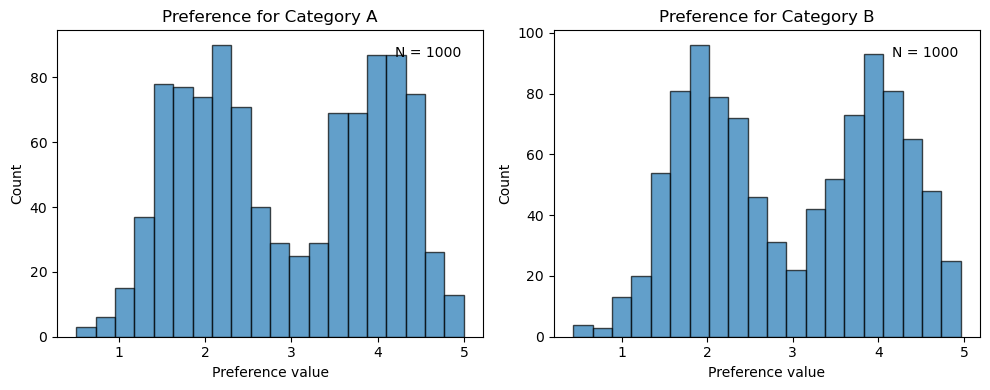

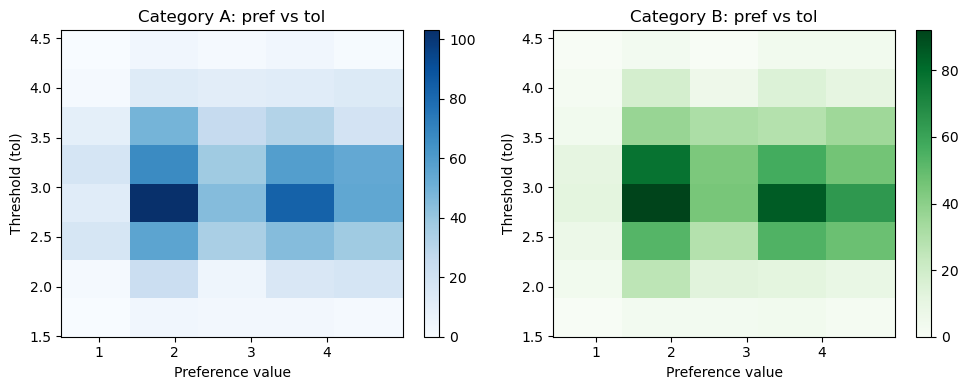

In [116]:
# 1D histograms for A and B with N label
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for pref, lab, ax in zip(
    (prefs_A, prefs_B),
    ("Preference for Category A", "Preference for Category B"),
    axes,
):
    ax.hist(pref, bins=20, edgecolor="black", alpha=0.7)
    ax.set_title(lab)
    ax.set_xlabel("Preference value")
    ax.set_ylabel("Count")
    ax.text(
        0.95, 0.95,
        f"N = {num_reviewers}",
        transform=ax.transAxes,
        ha="right", va="top",
        fontsize=10,
    )

plt.tight_layout()
plt.show()

# --------------------------------------------------
# 2D histogram: preference vs threshold (tol)
# x-axis: preference, y-axis: tol
# Make one plot for A and one for B
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Category A
h = axes[0].hist2d(prefs_A, tols, bins=[5, 8], cmap="Blues")  # [web:150][web:152]
axes[0].set_title("Category A: pref vs tol")
axes[0].set_xlabel("Preference value")
axes[0].set_ylabel("Threshold (tol)")
fig.colorbar(h[3], ax=axes[0])

# Category B
h = axes[1].hist2d(prefs_B, tols, bins=[5,8], cmap="Greens")
axes[1].set_title("Category B: pref vs tol")
axes[1].set_xlabel("Preference value")
axes[1].set_ylabel("Threshold (tol)")
fig.colorbar(h[3], ax=axes[1])

plt.tight_layout()
plt.show()

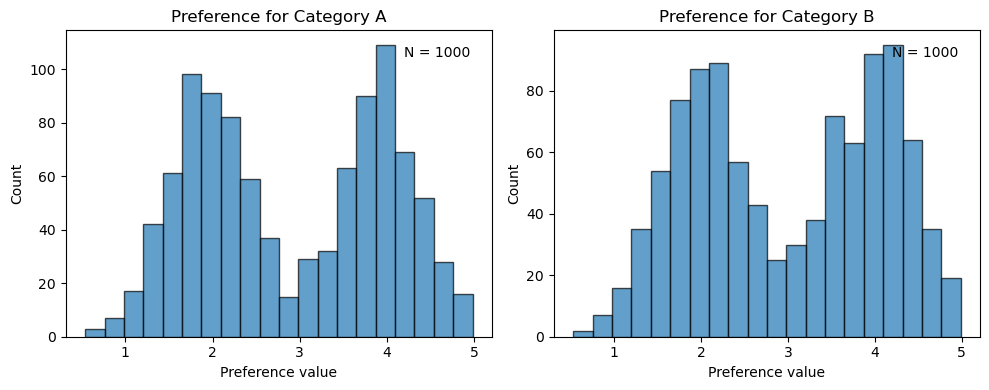

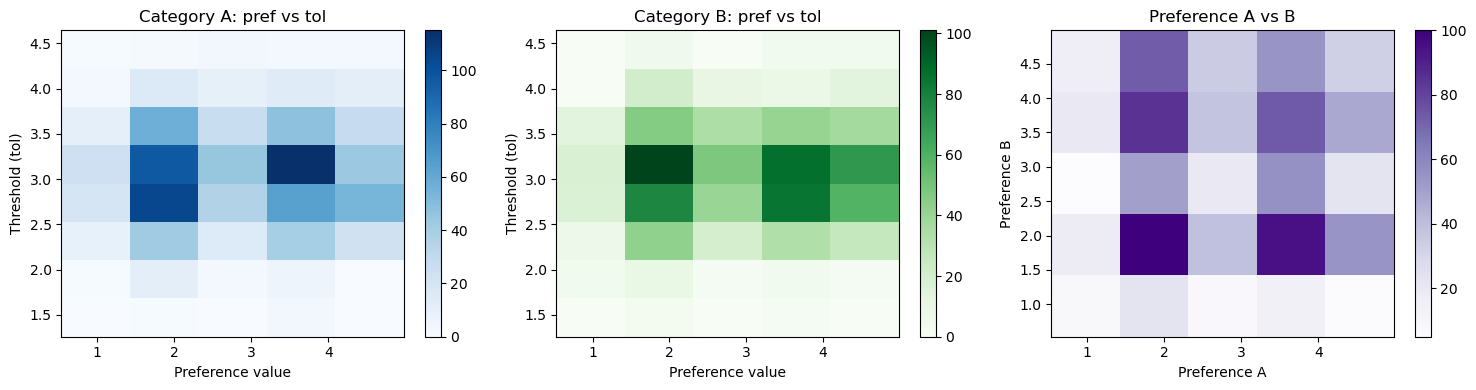

In [112]:
# 1D histograms for A and B with N label
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Panel 1: Category A
axes[0].hist(prefs_A, bins=20, edgecolor="black", alpha=0.7)
axes[0].set_title("Preference for Category A")
axes[0].set_xlabel("Preference value")
axes[0].set_ylabel("Count")
axes[0].text(
    0.95, 0.95,
    f"N = {num_reviewers}",
    transform=axes[0].transAxes,
    ha="right", va="top",
    fontsize=10,
)

# Panel 2: Category B
axes[1].hist(prefs_B, bins=20, edgecolor="black", alpha=0.7)
axes[1].set_title("Preference for Category B")
axes[1].set_xlabel("Preference value")
axes[1].set_ylabel("Count")
axes[1].text(
    0.95, 0.95,
    f"N = {num_reviewers}",
    transform=axes[1].transAxes,
    ha="right", va="top",
    fontsize=10,
)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Category A: pref vs tol
h = axes[0].hist2d(prefs_A, tols, bins=[5, 8], cmap="Blues")  # [web:150][web:157]
axes[0].set_title("Category A: pref vs tol")
axes[0].set_xlabel("Preference value")
axes[0].set_ylabel("Threshold (tol)")
fig.colorbar(h[3], ax=axes[0])

# Category B: pref vs tol
h = axes[1].hist2d(prefs_B, tols, bins=[5, 8], cmap="Greens")
axes[1].set_title("Category B: pref vs tol")
axes[1].set_xlabel("Preference value")
axes[1].set_ylabel("Threshold (tol)")
fig.colorbar(h[3], ax=axes[1])

# Panel 3: 2D histogram of prefs_A vs prefs_B
h = axes[2].hist2d(prefs_A, prefs_B, bins=[5, 5], cmap="Purples")
axes[2].set_title("Preference A vs B")
axes[2].set_xlabel("Preference A")
axes[2].set_ylabel("Preference B")
fig.colorbar(h[3], ax=axes[2])

plt.tight_layout()
plt.show()
